In [1]:
library(tidyverse)
library(reshape2)
library(org.At.tair.db)
library(clusterProfiler)
library(pheatmap)
library(ComplexHeatmap)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The follow

In [2]:
data <- read.csv('../kmers/dehydration_allDE_cluster.csv',row.name=1)

In [5]:
# GO analysis for each cluster
ego <- function (clu){
       enrichGO(gene          = rownames(data[data$cluster==clu,]),
                universe      = keys(org.At.tair.db), # use all arabidopsis genes as background genes
                OrgDb         = org.At.tair.db,
                keyType       = "TAIR",
#                 ont           = "BP",
#                 pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
#                 qvalueCutoff  = 0.05,
                readable      = FALSE)}


In [6]:
n <- 40 # cluster number
mergeGO <- data.frame(goTerm=0)
for (k in 1:n){
    curgo <- ego(k) %>% as.data.frame() %>% 
        unite(goTerm, ID,Description, sep='~') %>% select(c('goTerm','qvalue'))
    colnames(curgo) <- c('goTerm',k)
    mergeGO <- merge(mergeGO,curgo,by='goTerm',all=TRUE)
}
mergeGO <- mergeGO[-1,]
mergeGO[is.na(mergeGO)] <- 1.0
# mergeGO %>% filter_all(all_vars(.> 0.05))

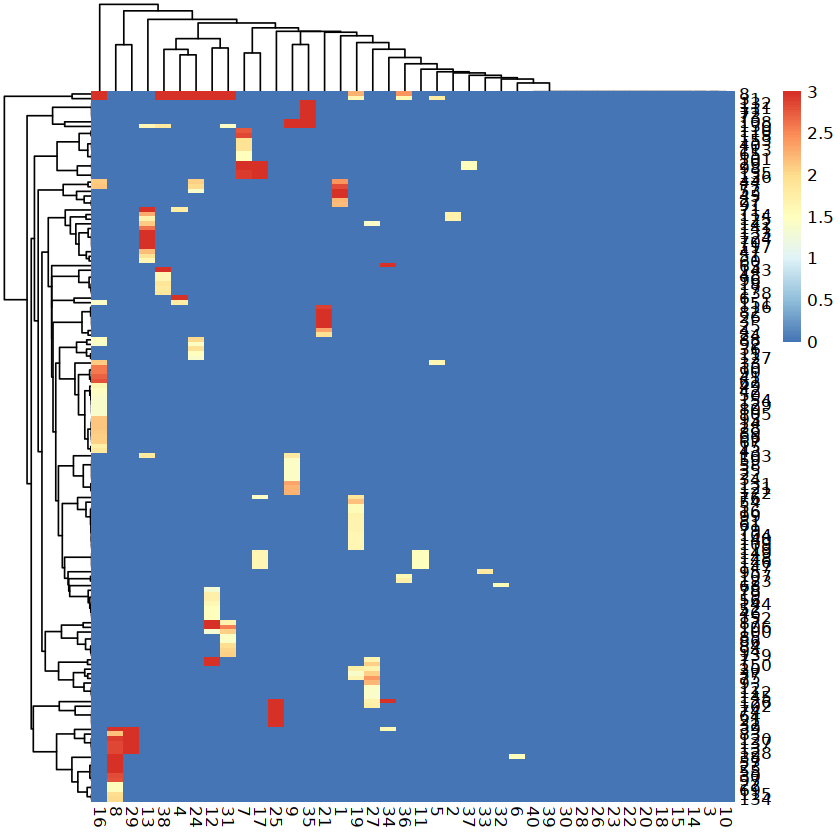

In [7]:
## all GO term heatmap
table = data.matrix(mergeGO[,-1])
log.table <- -log(table,base=10)
log.table[log.table > 3] = 3
pheatmap(log.table)

### Plot GOheatmap

png 
  2

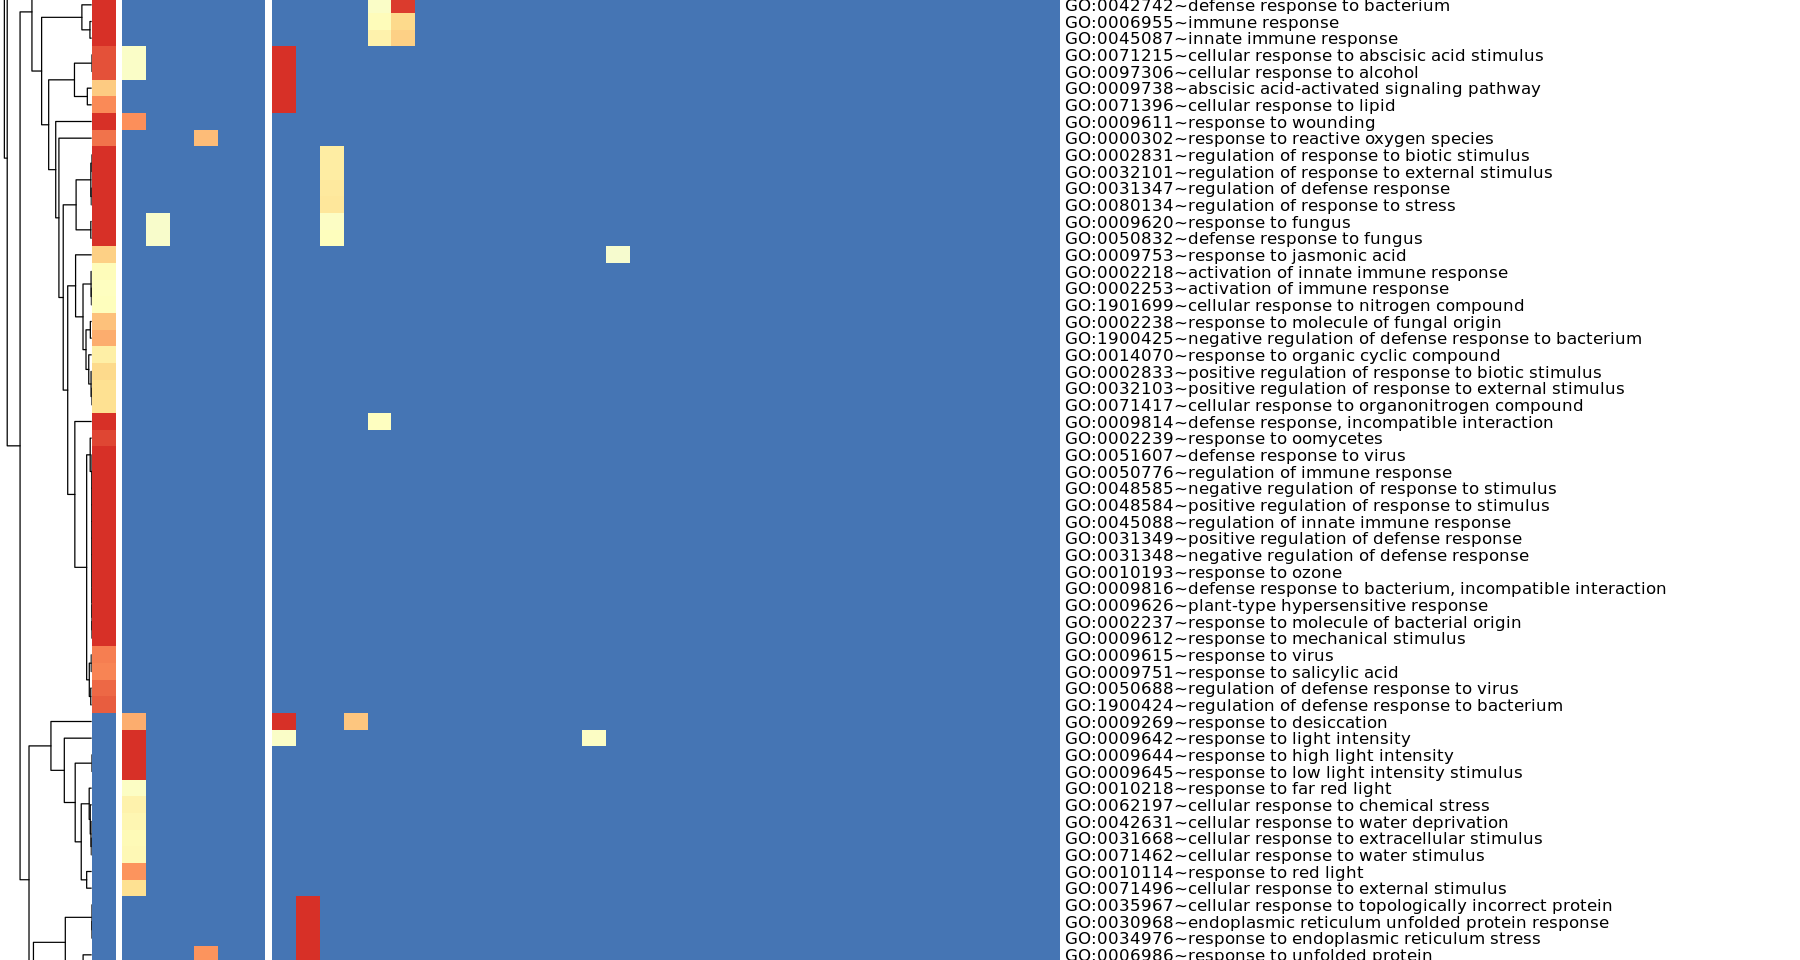

In [13]:
# filter GO responsive to stimuli
mergeGO_response <- mergeGO[grepl('respons|abscisic',mergeGO$goTerm),] %>% remove_rownames %>% column_to_rownames(var="goTerm")
table_response = data.matrix(mergeGO_response)
log.table_response <- -log(table_response,base=10)
log.table_response[log.table_response > 3] = 3

# library(RColorBrewer)
# colMain <- colorRampPalette(brewer.pal(8, "Blues"))(100)
options(repr.plot.width = 15, repr.plot.height = 8)
my_pheatmap <- pheatmap(log.table_response,
#          color = colMain,
        cutree_rows=3,
         cutree_cols=3,
        cellheight = 10)

get_plot_dims <- function(heat_map)
{
  plot_height <- sum(sapply(heat_map$gtable$heights, grid::convertHeight, "in"))
  plot_width  <- sum(sapply(heat_map$gtable$widths, grid::convertWidth, "in"))
  return(list(height = plot_height, width = plot_width))
}

plot_dims <- get_plot_dims(my_pheatmap)

tiff("GOheatmapRespose_p_value0.05.tiff", height = plot_dims$height, width = plot_dims$width+8, units = "in", res = 300)
my_pheatmap
dev.off()

### Plot individual GO dotplot

In [ ]:
# use geneRatio as x axis to plot
ggplot(as.data.frame(ego3),aes(x = GeneRatio,y = Description))+
    geom_point(aes(color = p.adjust,
                   size = Count))+
    scale_color_gradient(low = "red", high = "blue")+
    xlab("GeneRatio")+
    theme_bw()
# or use dotplot in clusterProfiler
# dotplot(ego)

In [12]:
# use Fold enrichment as x axis
# code from https://www.jieandze1314.com/post/cnposts/162/
library(stringr)
individualGO <- function(test,k){
    test <- as.data.frame(test)
    if (dim(test)[1]>0){ # in case no GO term found
        gr1 <- as.numeric(str_split(test$GeneRatio,"/",simplify = T)[,1])
    gr2 <- as.numeric(str_split(test$GeneRatio,"/",simplify = T)[,2])
    bg1 <- as.numeric(str_split(test$BgRatio,"/",simplify = T)[,1])
    bg2 <- as.numeric(str_split(test$BgRatio,"/",simplify = T)[,2])
    test$fold <- (gr1/gr2)/(bg1/bg2)
    test <- arrange(test,fold) # order by fold
    # to arrange y axis in order
    test$Description = factor(test$Description,levels = test$Description,ordered = T)
    # plot the results
    ggplot(test,aes(x = fold,y = Description))+
        geom_point(aes(color = p.adjust,
                       size = Count))+
        scale_color_gradient(low = "red", high = "blue")+
        xlab("Fold Enrichment")+
        theme_bw()+
        #edit legends from small to large
        guides(
            #reverse color order (higher value on top)
            color = guide_colorbar(reverse = TRUE))+
            #reverse size order (higher diameter on top) 
            #size = guide_legend(reverse = TRUE))
        # remove y axis title
        theme(axis.title.y = element_blank())+ ggsave(paste0('GO_cluster_',k,'.tiff'))
        
    }
    
        }
# plot GO dotplot for each cluster
n <- 40
for (i in 1:n) individualGO(ego(i),i)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



Saving 6.67 x 6.67 in image



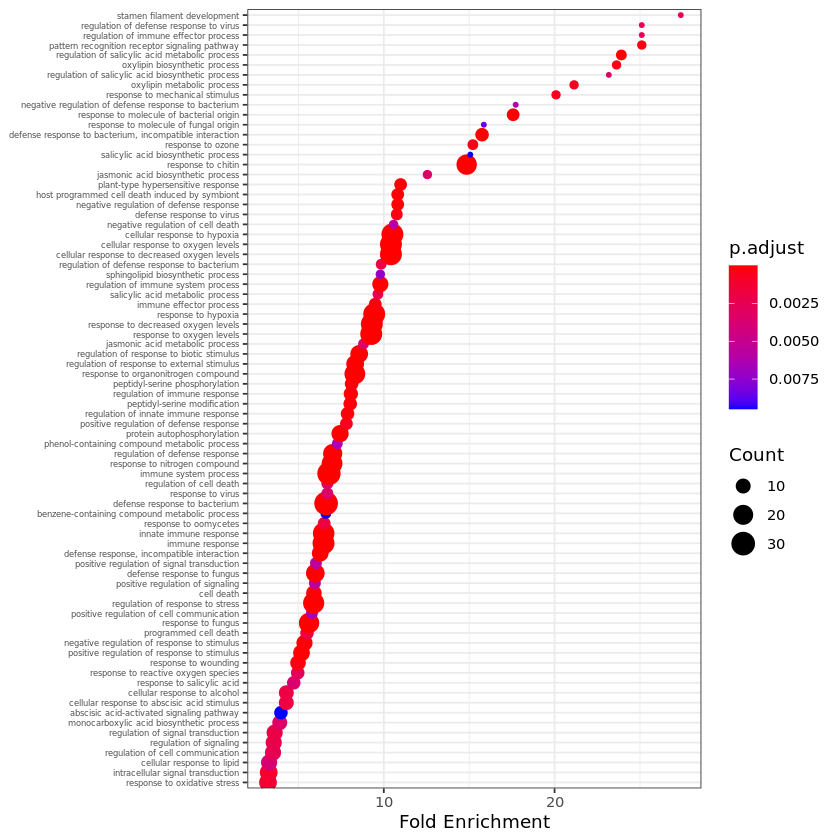

In [25]:
library(stringr)

individualGO2 <- function(test,k){
    test <- as.data.frame(test)
    if (dim(test)[1]>0){ # in case no GO term found
        gr1 <- as.numeric(str_split(test$GeneRatio,"/",simplify = T)[,1])
    gr2 <- as.numeric(str_split(test$GeneRatio,"/",simplify = T)[,2])
    bg1 <- as.numeric(str_split(test$BgRatio,"/",simplify = T)[,1])
    bg2 <- as.numeric(str_split(test$BgRatio,"/",simplify = T)[,2])
    test$fold <- (gr1/gr2)/(bg1/bg2)
    test <- arrange(test,fold) # order by fold
    # to arrange y axis in order
    test$Description = factor(test$Description,levels = test$Description,ordered = T)
    # plot the results
    ggplot(test,aes(x = fold,y = Description))+
        geom_point(aes(color = p.adjust,
                       size = Count))+
        scale_color_gradient(low = "red", high = "blue")+
        xlab("Fold Enrichment")+
        theme_bw()+
        #edit legends from small to large
        guides(
            #reverse color order (higher value on top)
            color = guide_colorbar(reverse = TRUE))+
            #reverse size order (higher diameter on top) 
            #size = guide_legend(reverse = TRUE))
#         scale_y_discrete(labels=function(y) str_wrap(y, width=10))+
        # remove y axis title, change font size of y ticks
        theme(axis.title.y = element_blank(),
             axis.text.y=element_text(size=5))+ 
        ggsave(paste0('GO_cluster_',k,'.tiff'))
        
    }
    
        }
individualGO2(ego(8),8)

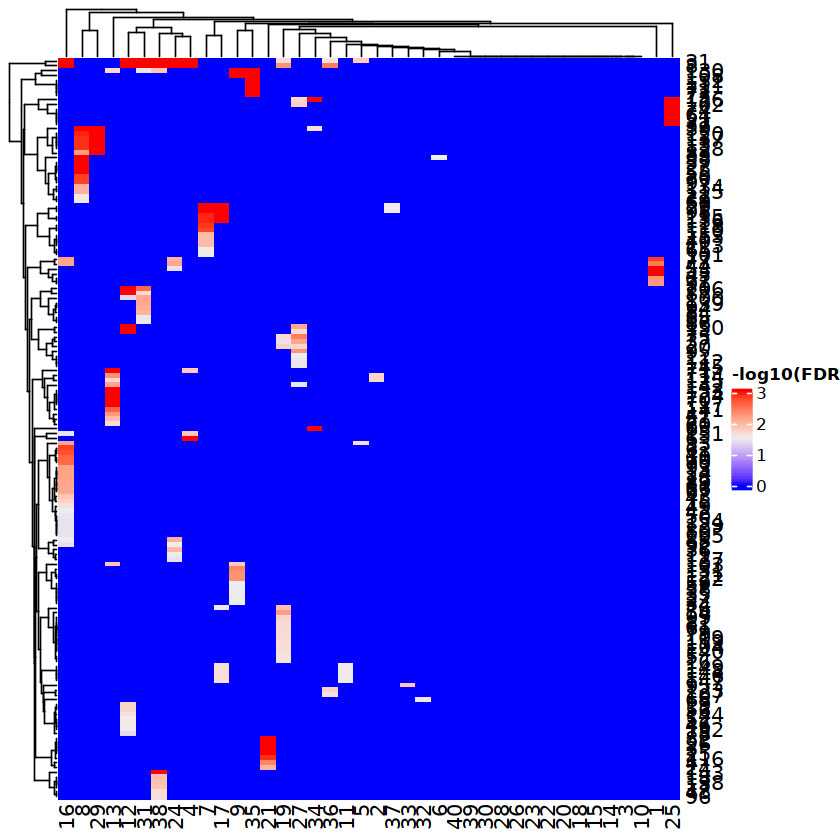

In [11]:
Heatmap(log.table, name='-log10(FDR)')

## agriGO results

In [39]:
## cutoff: pvalue = 0.05, FDR=0.05
n <- 40 # cluster number
mergeGO_FDR0.05 <- data.frame(GOterm=0)
for (k in 1:n){
    dd <- read.table(paste0('agriGO/',k,'.txt'),sep='\t',header = TRUE, 
                        stringsAsFactors = FALSE ) #stringsAsFactors to make first row as column names
    curgo <- dd %>% unite('GOterm',GO_acc, Term, sep='::') %>% 
    select(c('GOterm','FDR'))  %>% filter(FDR<0.05) %>% 
    setNames(c('GOterm',k))
    mergeGO_FDR0.05 <- merge(mergeGO_FDR0.05,curgo,by='GOterm',all=TRUE)
}
mergeGO_FDR0.05 <- mergeGO_FDR0.05[-1,]
mergeGO_FDR0.05[is.na(mergeGO_FDR0.05)] <- 1.0

In [ ]:
## all GO term heatmap
table = data.matrix(mergeGO_FDR0.05[,-1])
log.table <- -log(table,base=10)
log.table[log.table > 3] = 3

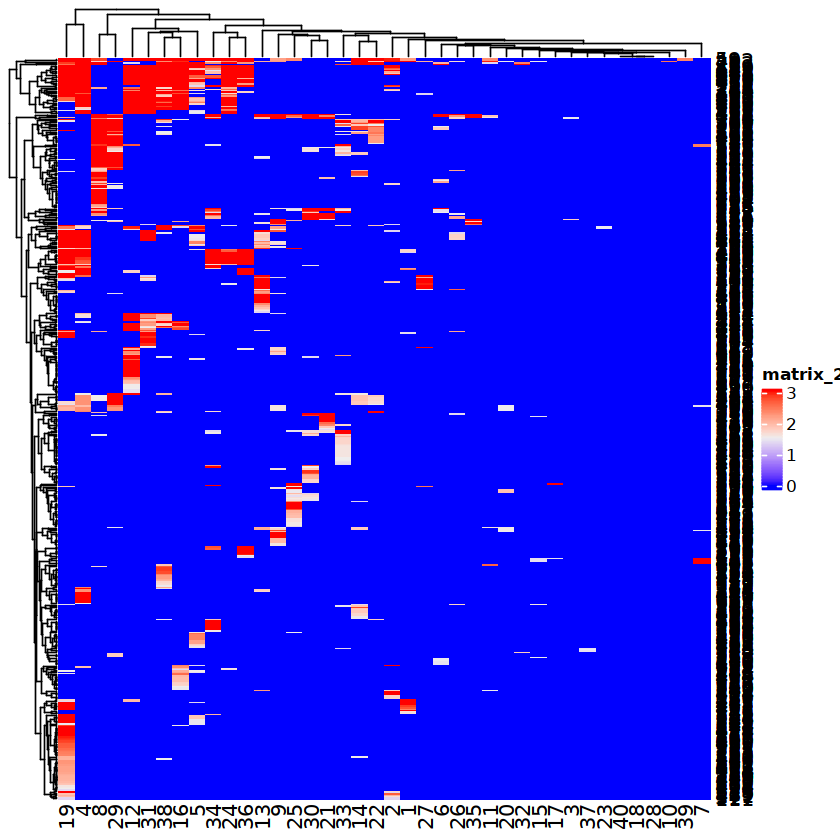

In [74]:
Heatmap(log.table)

In [70]:
# filter GO responsive to stimuli
mergeGO_response <- mergeGO_FDR0.05[grepl('respons|abscisic',mergeGO_FDR0.05$GOterm),] %>% remove_rownames %>% column_to_rownames(var="GOterm")
rownames(mergeGO_response) <- sapply(rownames(mergeGO_response),function(x) strsplit(x,split='::')[[1]][2])

table_response = data.matrix(mergeGO_response)
log.table_response <- -log(table_response,base=10)
log.table_response[log.table_response > 3] = 3

# Heatmap
tiff('agriGO_response_heatmap.tiff',units="in", width=10, height=10, res=300)
pheatmap(log.table_response)
dev.off()

png 
  2

In [75]:
## cutoff: pvalue = 0.05, no restriction on FDR
n <- 40 # cluster number
mergeGO_FDRall <- data.frame(GOterm=0)
for (k in 1:n){
    dd <- read.table(paste0('agriGO/',k,'.txt'),sep='\t',header = TRUE, 
                        stringsAsFactors = FALSE ) #stringsAsFactors to make first row as column names
    curgo <- dd %>% unite('GOterm',GO_acc, Term, sep='::') %>% 
    select(c('GOterm','pvalue')) %>% 
    setNames(c('GOterm',k))
    mergeGO_FDRall <- merge(mergeGO_FDRall,curgo,by='GOterm',all=TRUE)
}
mergeGO_FDRall <- mergeGO_FDRall[-1,]
mergeGO_FDRall[is.na(mergeGO_FDRall)] <- 1.0

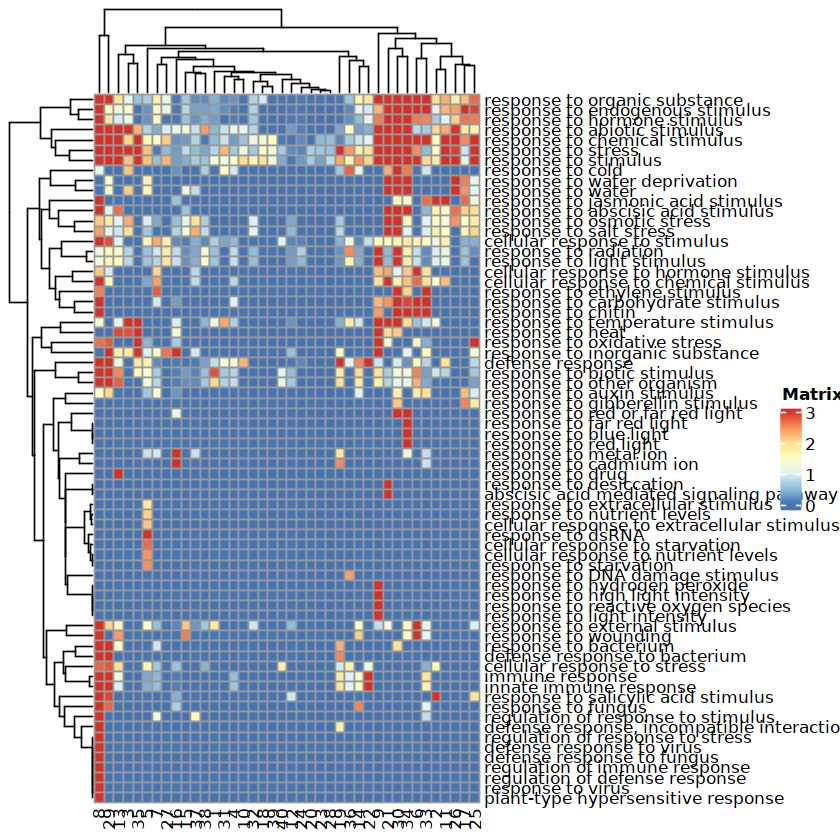

In [76]:
# filter GO responsive to stimuli
mergeGO_response <- mergeGO_FDRall[grepl('respons|abscisic',mergeGO_FDRall$GOterm),] %>% remove_rownames %>% column_to_rownames(var="GOterm")
rownames(mergeGO_response) <- sapply(rownames(mergeGO_response),function(x) strsplit(x,split='::')[[1]][2])

table_response = data.matrix(mergeGO_response)
log.table_response <- -log(table_response,base=10)
log.table_response[log.table_response > 3] = 3

# Heatmap
# tiff('agriGO_response_heatmap_nofilter.tiff',units="in", width=10, height=10, res=300)
pheatmap(log.table_response)
# dev.off()